# Code 2: Exploratory Analysis of Bayesian Models

```{admonition} This is a reference notebook for the book Bayesian Modeling and Computation in Python
:class: tip, dropdown
The textbook is not needed to use or run this code, though the context and explanation is missing from this notebook.

If you'd like a copy it's available
[from the CRC Press](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368)
or from [Amazon](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368).
``

In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc3 as pm
from scipy import stats
import theano.tensor as tt
from plotnine import *

In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 100
np.random.seed(5201)

## Understanding Your Assumptions

### Figure 2.2

+ player kicks the goal from the penalty spot towards the goal
+ But the kick has some noise applied to it which causes a deviation $\sigma$ from the straight line path
+ The deviation is expressed in terms of an angle away from 0 (with 0 being a straight line kick)
+ In order to score a goal the kick angle $\alpha$ has to be within the angle limits of the goals as seen from the penalty spot
+ Based on the geometry the kick angle has to be within +/- 18.4 degrees
+ So $p(|\alpha| < tan^{-1}(\frac{L}{x})$ is expressed as 2 x the standard normal cumulative distribution ie $2\times\Phi(\frac{tan^{-1}(\frac{L}{x})}{\sigma}) -1$ ? - need to work through this
+ $p(goal) = 2\times\Phi(\frac{tan^{-1}(\frac{L}{x})}{\sigma}) -1$
+ $\sigma$ is a Half Normal distribution centred at 0, and with a standard devistion of $\sigma_{\sigma}$

In [3]:
half_length = 3.66  # meters - half width of goal
penalty_point = 11  # meters - shortest distance from penalty spot to goal line
def Phi(x):
    """Calculates the standard normal cumulative distribution function."""
    return 0.5 + 0.5 * tt.erf(x / tt.sqrt(2.0))

In [4]:
max_angle_radians = np.arctan(half_length/penalty_point)
print(max_angle_radians)
max_angle_degrees = np.degrees(max_angle_radians)
print(max_angle_degrees)

0.3212050007137233
18.40369089939294


In [5]:
def prob_goal(sigma):
    return 2 * Phi(tt.arctan(half_length / penalty_point) / sigma) - 1
angular_deviation = 0.001
print(f"angular_deviation: {angular_deviation} degrees, prob(goal) {prob_goal(np.deg2rad(angular_deviation)).eval()}")
angular_deviation = 1
print(f"angular_deviation: {angular_deviation} degrees, prob(goal) {prob_goal(np.deg2rad(angular_deviation)).eval()}")
angular_deviation = 19
print(f"angular_deviation: {angular_deviation} degrees, prob(goal) {prob_goal(np.deg2rad(angular_deviation)).eval()}")
angular_deviation = 180
print(f"angular_deviation: {angular_deviation} degrees, prob(goal) {prob_goal(np.deg2rad(angular_deviation)).eval()}")

angular_deviation: 0.001 degrees, prob(goal) 1.0
angular_deviation: 1 degrees, prob(goal) 1.0
angular_deviation: 19 degrees, prob(goal) 0.6672628468058046
angular_deviation: 180 degrees, prob(goal) 0.08143598737092916


In [6]:
ppss = []
sigmas_deg = [5, 20, 60]
sigmas_rad = np.deg2rad(sigmas_deg)
for sigma in sigmas_rad:
    with pm.Model() as model:
        σ = pm.HalfNormal("σ", sigma)
        α = pm.Normal("α", 0, σ)
        p_goal = pm.Deterministic("p_goal", 2 * Phi(tt.arctan(half_length / penalty_point) / σ) - 1)
        pps = pm.sample_prior_predictive(250)
        ppss.append(pps)

In [7]:
pps.keys()

dict_keys(['σ_log__', 'p_goal', 'σ', 'α'])

In [8]:
pps['p_goal'].shape

(250,)

max angle: 18.40369089939294


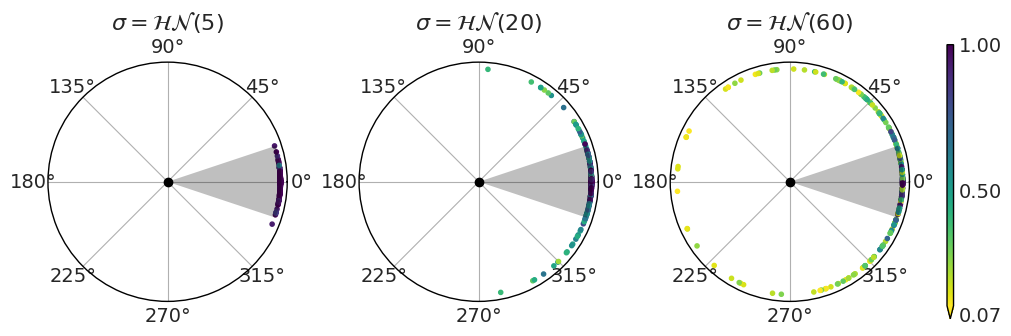

In [9]:
fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection="polar"), figsize=(10, 4))

max_angle = np.arctan(half_length/penalty_point)
print(f"max angle: {np.rad2deg(max_angle)}")

for sigma, pps, ax in zip(sigmas_deg, ppss, axes):
    # Restrict the probabilities shown using a minimum cutoff value to make a mask
    p_cutoff = 0.07
    cutoff = pps["p_goal"] > p_cutoff
    cax = ax.scatter(pps["α"][cutoff], np.ones_like(pps["α"][cutoff]), c=pps["p_goal"][cutoff],
               marker=".", cmap="viridis_r", vmin=0.1)
    # Shaded area between -18.4 and + 18.4 degreees
    ax.fill_between(np.linspace(-max_angle, max_angle, 100), 0, 1.01, alpha=0.25)
    ax.set_yticks([])
    ax.set_title(f"$\sigma = \mathcal{{HN}}({sigma})$")
    ax.plot(0,0, 'o')
fig.colorbar(cax, extend="min", ticks=[1, 0.5, p_cutoff], shrink=0.7, aspect=40)

plt.savefig("img/chp02/prior_predictive_distributions_00.png", bbox_inches="tight")

### Figure 2.3

In [10]:
from scipy.special import expit
help(expit)

Help on ufunc:

expit = <ufunc 'expit'>
    expit(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])
    
    expit(x)
    
    Expit (a.k.a. logistic sigmoid) ufunc for ndarrays.
    
    The expit function, also known as the logistic sigmoid function, is
    defined as ``expit(x) = 1/(1+exp(-x))``.  It is the inverse of the
    logit function.
    
    Parameters
    ----------
    x : ndarray
        The ndarray to apply expit to element-wise.
    
    Returns
    -------
    out : ndarray
        An ndarray of the same shape as x. Its entries
        are `expit` of the corresponding entry of x.
    
    See Also
    --------
    logit
    
    Notes
    -----
    As a ufunc expit takes a number of optional
    keyword arguments. For more information
    see `ufuncs <https://docs.scipy.org/doc/numpy/reference/ufuncs.html>`_
    
    .. versionadded:: 0.10.0
    
    Examples
    --------
    >>> from scipy.special import expit

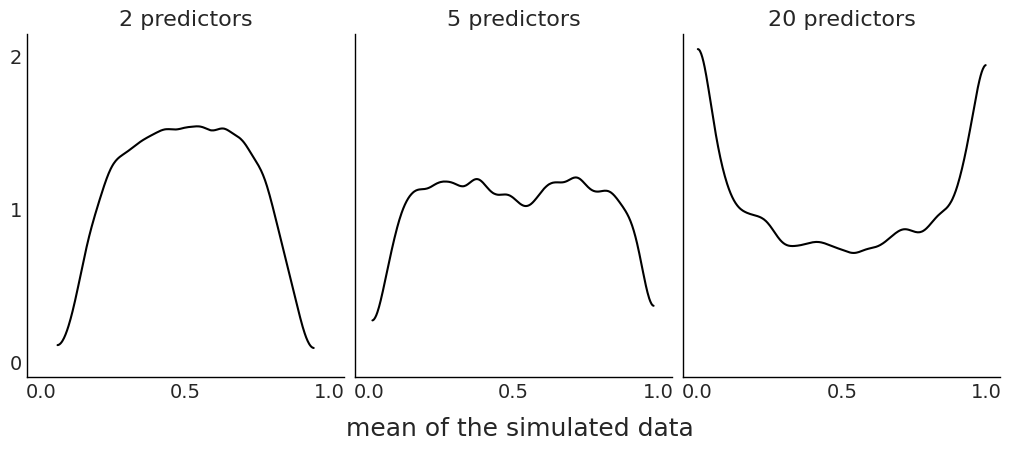

In [11]:
from scipy.special import expit
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True,  sharey=True)
axes = np.ravel(axes)

for dim, ax in zip([2, 5, 20], axes):
    β = np.random.normal(0, 1, size=(10000, dim))
    X = np.random.binomial(n=1, p=0.75, size=(dim, 500))
    az.plot_kde(expit(β @ X).mean(1), ax=ax) # ?? @ symbol used here ??
    ax.set_title(f"{dim} predictors")
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 1, 2])

fig.text(0.34, -0.075, size=18, s="mean of the simulated data")
plt.savefig("img/chp02/prior_predictive_distributions_01.png", bbox_inches="tight")

## Takeaways
+ Use `pm.sample_prior_predictive(n_samples)` to sample from the priors
+ Returns a dictionary of the priors and calculated distributions
+ Plot/check the returned data to see that the prior is reasonable

## Understanding Your Predictions

### Figure 2.4

In [12]:
n_samples = 125
prop = 0.65
Y = stats.bernoulli(prop).rvs(n_samples)
with pm.Model() as model:
    θ = pm.Beta("θ", 1, 1)
    y_obs = pm.Binomial("y_obs",n=1, p=θ, observed=Y)
    trace_b = pm.sample(1000)

/tmp/ipykernel_775533/3246336100.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [13]:
trace_b

<MultiTrace: 4 chains, 1000 iterations, 2 variables>

In [14]:
# dir(trace_b)
print(f"trace_b.chains: {trace_b.chains}")
print(f"trace_b.stat_names: {trace_b.stat_names}")
print(f"trace_b.points: {list(trace_b.points())[0:5]}")
print(f"trace_b.get_sampler_stats(): {trace_b.get_sampler_stats('mean_tree_accept')}")
print(f"trace_b.report: {trace_b.report}")

trace_b.chains: [0, 1, 2, 3]
trace_b.stat_names: {'depth', 'diverging', 'energy_error', 'energy', 'process_time_diff', 'perf_counter_diff', 'perf_counter_start', 'tree_size', 'mean_tree_accept', 'step_size_bar', 'max_energy_error', 'model_logp', 'step_size', 'tune'}
trace_b.points: [{'θ_logodds__': 0.5986103589107417, 'θ': 0.6453383139310385}, {'θ_logodds__': 0.4902216443687287, 'θ': 0.6201586447020663}, {'θ_logodds__': 0.4902216443687287, 'θ': 0.6201586447020663}, {'θ_logodds__': 0.3880976192739442, 'θ': 0.5958246561060466}, {'θ_logodds__': 0.5432096361284373, 'θ': 0.6325587445129652}]
trace_b.get_sampler_stats(): [0.99613429 0.90065557 0.39401705 ... 0.47525625 0.68254158 0.86880097]
trace_b.report: <pymc3.backends.report.SamplerReport object at 0x7f90d36f8580>


In [15]:
pred_dist = pm.sample_posterior_predictive(trace_b, 1000, model=model)["y_obs"]

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample


In [16]:
pred_dist

array([[0, 0, 1, ..., 0, 1, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 1, 1],
       [0, 1, 1, ..., 0, 1, 1]])

In [17]:
pred_dist.shape

(1000, 125)

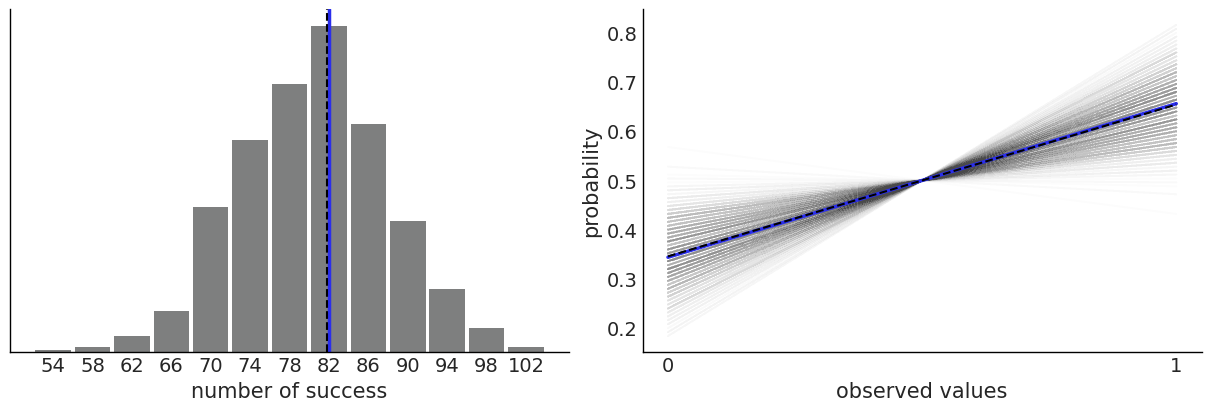

In [18]:
_, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

az.plot_dist(pred_dist.sum(1),
             hist_kwargs={"color":"C2"}, ax=ax[0])
ax[0].axvline(Y.sum(), color="C4", lw=2.5);
ax[0].axvline(pred_dist.sum(1).mean(), color="k", ls="--")
ax[0].set_yticks([])
ax[0].set_xlabel("number of success")


pps_ = pred_dist.mean(1)
ax[1].plot((np.zeros_like(pps_), np.ones_like(pps_)), (1-pps_, pps_), 'C1', alpha=0.01)

ax[1].plot((0, 1), (1-Y.mean(), Y.mean()), 'C4', lw=2.5)
ax[1].plot((0, 1), (1-pps_.mean(), pps_.mean()), 'k--')
ax[1].set_xticks((0,1))
ax[1].set_xlabel("observed values")
ax[1].set_ylabel("probability")
plt.savefig("img/chp02/posterior_predictive_check.png")

### Figure 2.5

In [19]:
idata = az.from_dict(posterior_predictive={"y":pred_dist.reshape(2, 500, n_samples)}, observed_data={"y":Y})

In [20]:
idata

Inference data with groups:
	> posterior_predictive
	> observed_data

In [21]:
help(az.plot_bpv)

Help on function plot_bpv in module arviz.plots.bpvplot:

plot_bpv(data, kind='u_value', t_stat='median', bpv=True, plot_mean=True, reference='analytical', mse=False, n_ref=100, hdi_prob=0.94, color='C0', grid=None, figsize=None, textsize=None, data_pairs=None, var_names=None, filter_vars=None, coords=None, flatten=None, flatten_pp=None, ax=None, backend=None, plot_ref_kwargs=None, backend_kwargs=None, group='posterior', show=None)
    Plot Bayesian p-value for observed data and Posterior/Prior predictive.
    
    Parameters
    ----------
    data : az.InferenceData object
        InferenceData object containing the observed and posterior/prior predictive data.
    kind : str
        Type of plot to display ("p_value", "u_value", "t_stat"). Defaults to u_value.
        For "p_value" we compute p := p(y* ≤ y | y). This is the probability of the data y being
        larger or equal than the predicted data y*. The ideal value is 0.5 (half the predictions
        below and half above the

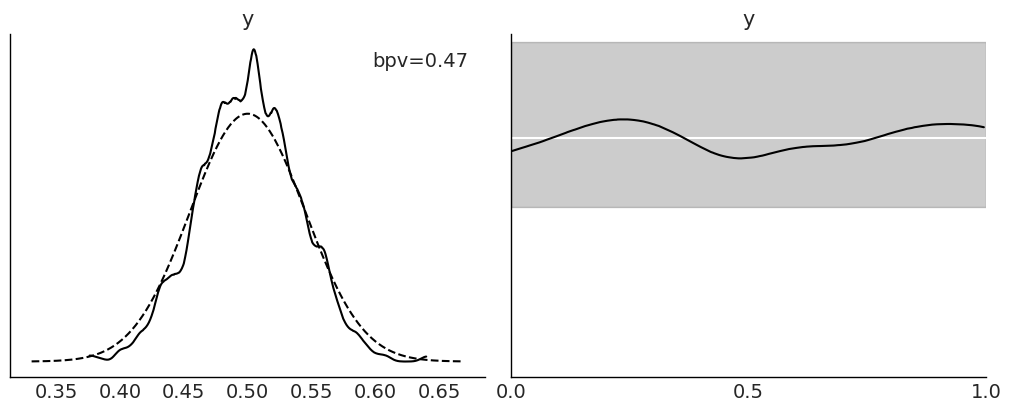

In [22]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
az.plot_bpv(idata, kind="p_value", ax=ax[0])
ax[0].legend([f"bpv={(Y.mean() > pred_dist.mean(1)).mean():.2f}"], handlelength=0)
az.plot_bpv(idata, kind="u_value", ax=ax[1])
ax[1].set_yticks([])
ax[1].set_xticks([0., 0.5, 1.])
plt.savefig("img/chp02/posterior_predictive_check_pu_values.png")

### Figure 2.6

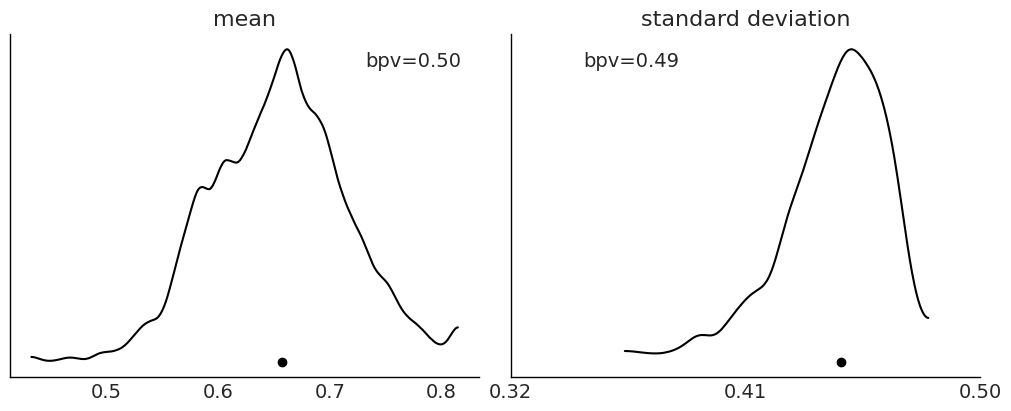

In [23]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
az.plot_bpv(idata, kind="t_stat", t_stat="mean", ax=ax[0])
ax[0].set_title("mean")
az.plot_bpv(idata, kind="t_stat", t_stat="std", ax=ax[1])
ax[1].set_title("standard deviation")
ax[1].set_xticks([0.32, 0.41, 0.5])
plt.savefig("img/chp02/posterior_predictive_check_tstat.png")

### Figure 2.7

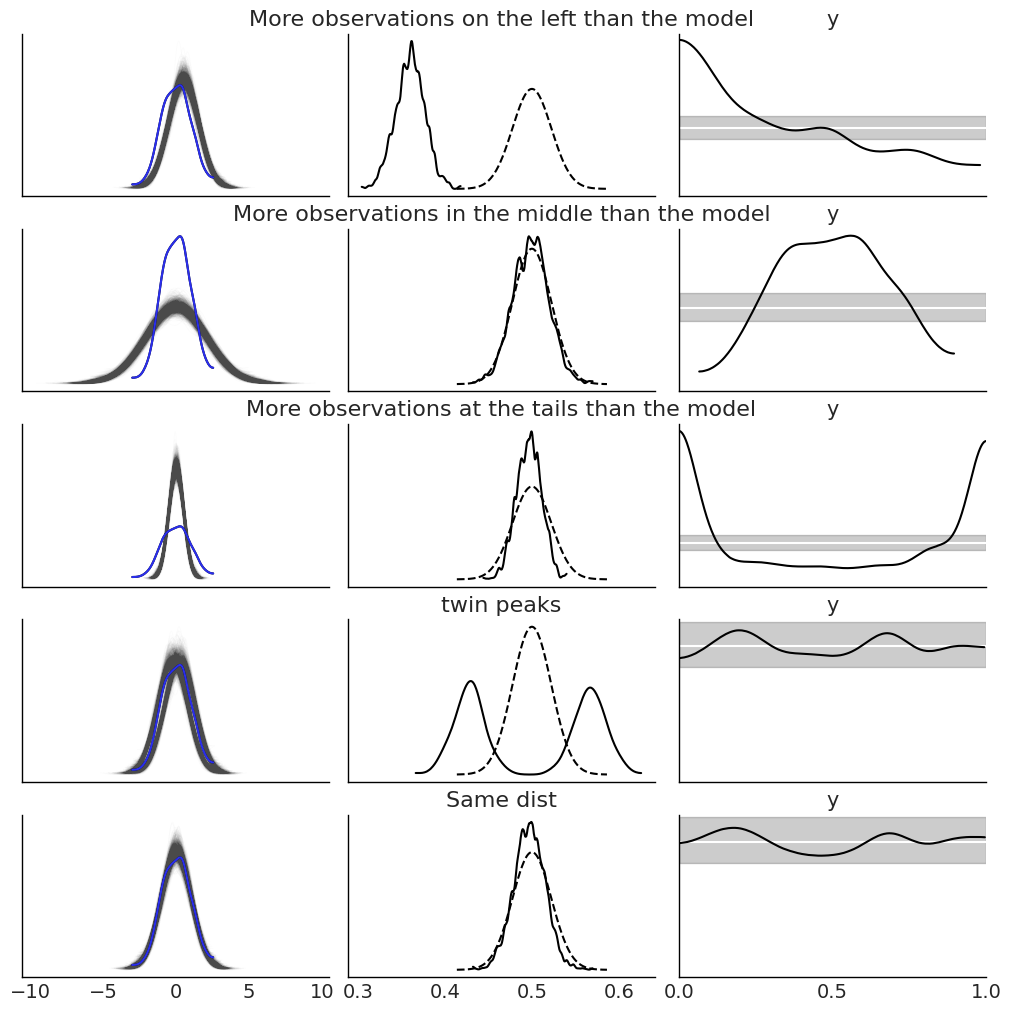

In [24]:
plt.rcParams['figure.dpi'] = 100
n_obs = 500
samples = 2000
y_obs = np.random.normal(0, 1, size=n_obs)

idata1 = az.from_dict(posterior_predictive={"y":np.random.normal(0.5, 1, size=(1, samples, n_obs))},
                      observed_data={"y":y_obs})

idata2 = az.from_dict(posterior_predictive={"y":np.random.normal(0, 2, size=(1, samples, n_obs))},
                      observed_data={"y":y_obs})

idata3 = az.from_dict(posterior_predictive={"y":np.random.normal(0, 0.5, size=(1, samples,n_obs))},
                      observed_data={"y":y_obs})

idata4 = az.from_dict(posterior_predictive={"y":np.concatenate(
                                                [np.random.normal(-0.25, 1, size=(1, samples//2, n_obs)),
                                                 np.random.normal(0.25, 1, size=(1, samples//2, n_obs))]
                                                                )},
                      observed_data={"y":y_obs})
idata5 = az.from_dict(posterior_predictive={"y":np.random.normal(0, 1, size=(1, samples, n_obs))},
                      observed_data={"y":y_obs})

idatas = [idata1,
          idata2,
          idata3,
          idata4,
          idata5
]

_, axes = plt.subplots(len(idatas), 3, figsize=(10, 10), sharex="col")
labels = ["More observations on the left than the model", "More observations in the middle than the model", 
          "More observations at the tails than the model", "twin peaks", "Same dist"]
for idata, ax, label in zip(idatas, axes, labels):
    az.plot_ppc(idata, ax=ax[0], color="C1", alpha=0.01, mean=False, legend=False)
    az.plot_kde(idata.observed_data["y"], ax=ax[0], plot_kwargs={"color":"C4", "zorder":3})
    ax[0].set_xlabel("")
    az.plot_bpv(idata, kind="p_value", ax=ax[1])
    az.plot_bpv(idata, kind="u_value", ax=ax[2])
    ax[2].set_yticks([])
    ax[2].set_xticks([0., 0.5, 1.])
    for ax_ in ax[:-1]:
        ax_.set_title("")
    ax_.set_title(label)

plt.savefig("img/chp02/posterior_predictive_many_examples.png")

## Diagnosing Numerical Inference

### Code 2.1

In [25]:
np.random.seed(5201)

In [26]:
good_chains = stats.beta.rvs(2, 5,size=(2, 2000))
bad_chains0 = np.random.normal(np.sort(good_chains, axis=None), 0.05,
                               size=4000).reshape(2, -1)

bad_chains1 = good_chains.copy()
for i in np.random.randint(1900, size=4):
    bad_chains1[i%2:,i:i+100] = np.random.beta(i, 950, size=100)

chains = {"good_chains":good_chains,
          "bad_chains0":bad_chains0,
          "bad_chains1":bad_chains1}

In [27]:
print(chains["good_chains"].shape)
print(chains["bad_chains0"].shape)
print(chains["bad_chains1"].shape)

(2, 2000)
(2, 2000)
(2, 2000)


### Code 2.2

+ ess - estimate effective sample size

In [28]:
az.ess(chains)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 4.389e+03
    bad_chains0  float64 2.436
    bad_chains1  float64 111.1

### Code 2.3 and Figure 2.8

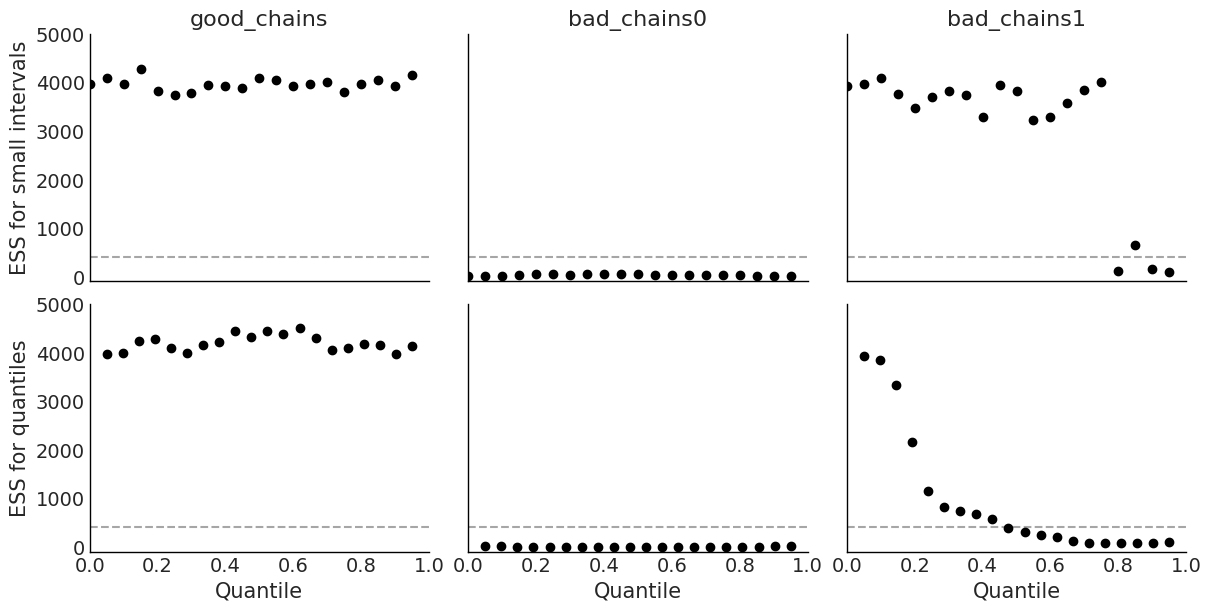

In [29]:
_, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True, sharex=True)
az.plot_ess(chains, kind="local", ax=axes[0])
az.plot_ess(chains, kind="quantile", ax=axes[1])

for ax_ in axes[0]:
    ax_.set_xlabel("")
for ax_ in axes[1]:
    ax_.set_title("")

for ax_ in axes[:,1:].ravel():
    ax_.set_ylabel("")
plt.ylim(-100, 5000)
plt.savefig("img/chp02/plot_ess.png")

### Code 2.4

In [30]:
az.rhat(chains)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 1.0
    bad_chains0  float64 2.408
    bad_chains1  float64 1.033

### Code 2.5

In [31]:
az.mcse(chains)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 0.002381
    bad_chains0  float64 0.1077
    bad_chains1  float64 0.01781

### Code 2.6 and Figure 2.9

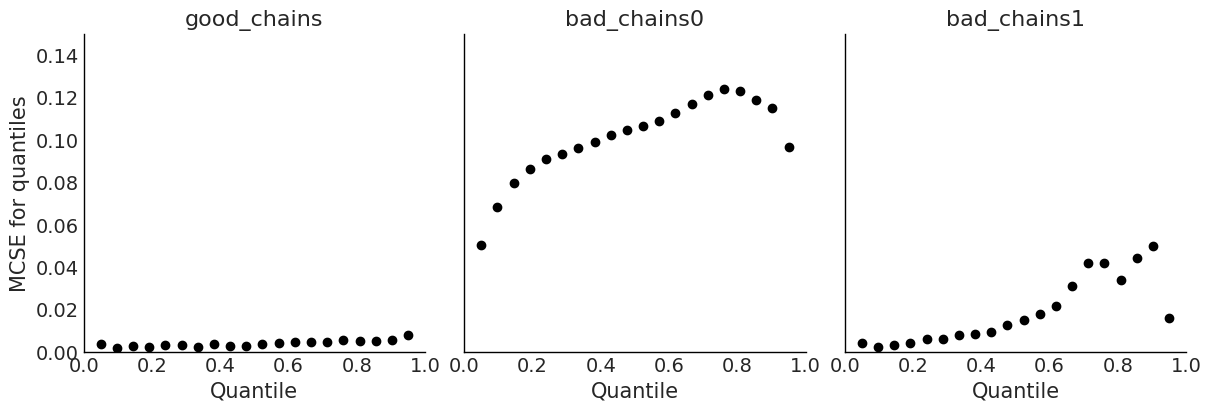

In [32]:
_, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
az.plot_mcse(chains, ax=axes)
for ax_ in axes[1:]:
    ax_.set_ylabel("")
    ax_.set_ylim(0, 0.15)

plt.savefig("img/chp02/plot_mcse.png")

### Code 2.7

In [33]:
az.summary(chains, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
good_chains,0.002,0.002,4389.0,3966.0,1.00
bad_chains0,0.108,0.088,2.0,11.0,2.41
bad_chains1,0.018,0.013,111.0,105.0,1.03


### Code 2.8 and Figure 2.10

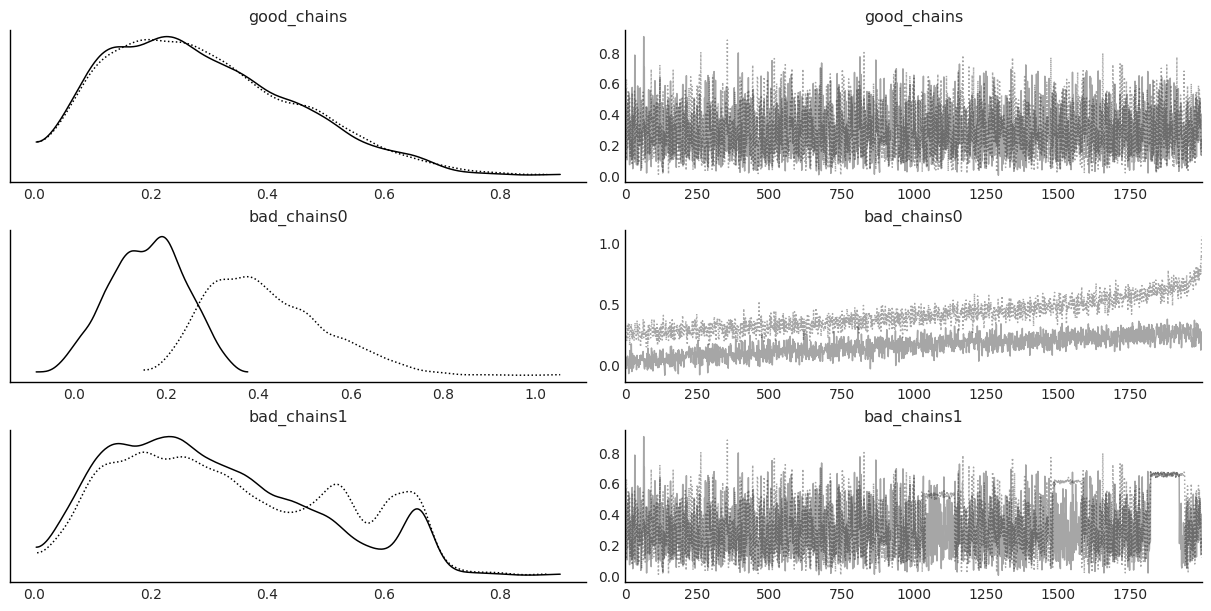

In [34]:
az.plot_trace(chains)
plt.savefig("img/chp02/trace_plots.png")

### Code 2.9 and Figure 2.11

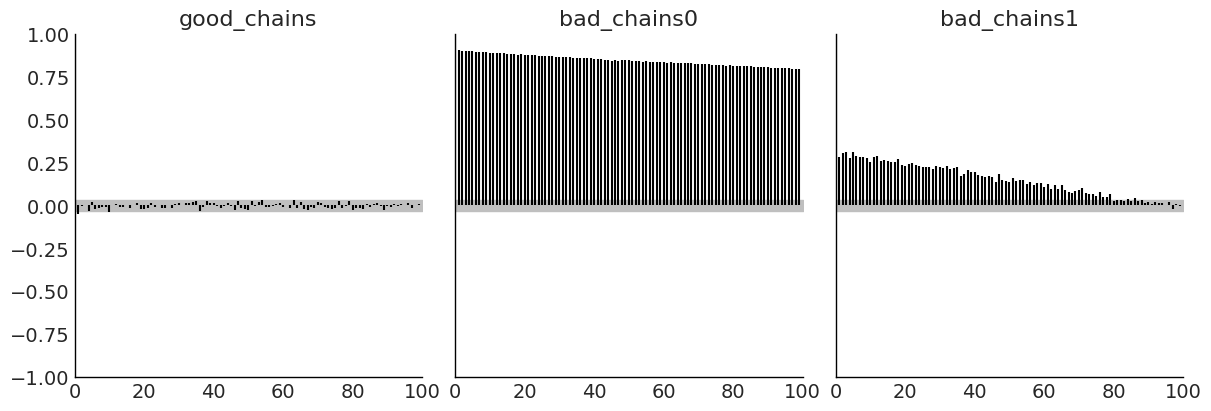

In [35]:
az.plot_autocorr(chains, combined=True, figsize=(12, 4))
plt.savefig('img/chp02/autocorrelation_plot.png')

### Code 2.10 and Figure 2.12

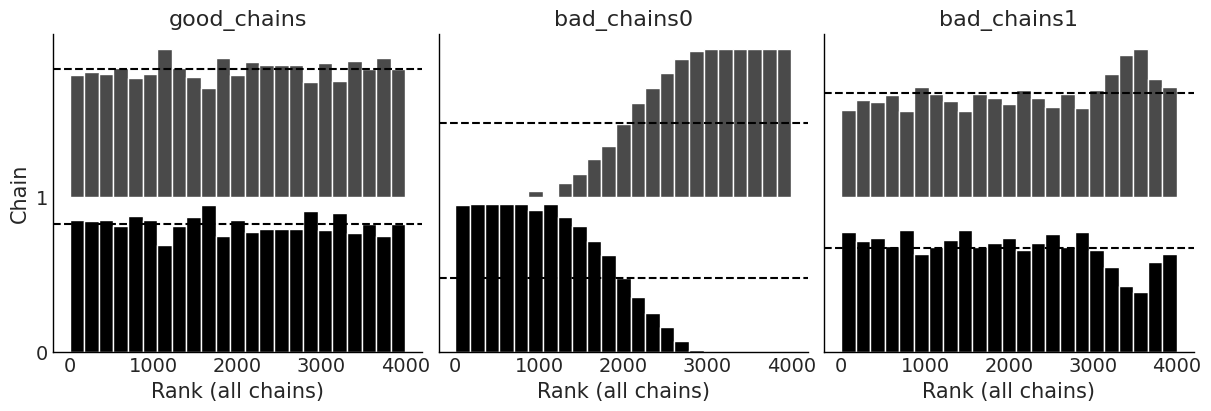

In [36]:
_, axes = plt.subplots(1, 3, figsize=(12, 4))
az.plot_rank(chains, kind="bars", ax=axes)
for ax_ in axes[1:]:
    ax_.set_ylabel("")
    ax_.set_yticks([])

plt.savefig('img/chp02/rank_plot_bars.png')

### Code 2.11 and Figure 2.13

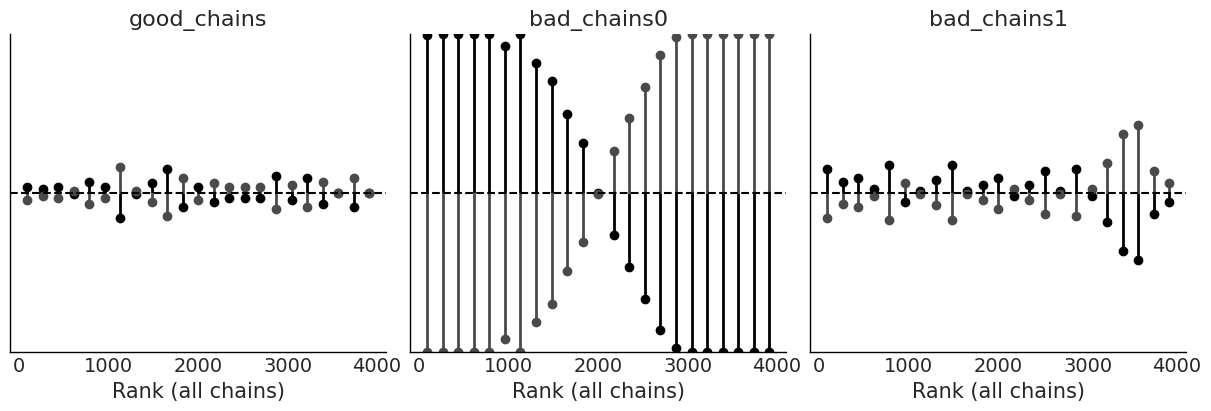

In [37]:
az.plot_rank(chains, kind="vlines", figsize=(12, 4))
plt.savefig('img/chp02/rank_plot_vlines.png')

### Code 2.12, 2.13, and 2.14

In [38]:
with pm.Model() as model_0:
    θ1 = pm.Normal("θ1", 0, 1, testval=0.1)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_0 = pm.sample(return_inferencedata=True)

with pm.Model() as model_1:
    θ1 = pm.HalfNormal("θ1", 1 / (2/np.pi)**0.5)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_1 = pm.sample(return_inferencedata=True)

with pm.Model() as model_1bis:
    θ1 = pm.HalfNormal("θ1", 1 / (2/np.pi)**0.5)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_1bis = pm.sample(return_inferencedata=True, target_accept=0.95)

idatas = [idata_0, idata_1, idata_1bis]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ2, θ1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 503 divergences after tuning. Increase `target_accept` or reparameterize.
There were 579 divergences after tuning. Increase `target_accept` or reparameterize.
There were 614 divergences after tuning. Increase `target_accept` or reparameterize.
There were 604 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ2, θ1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ2, θ1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


### Figure 2.14

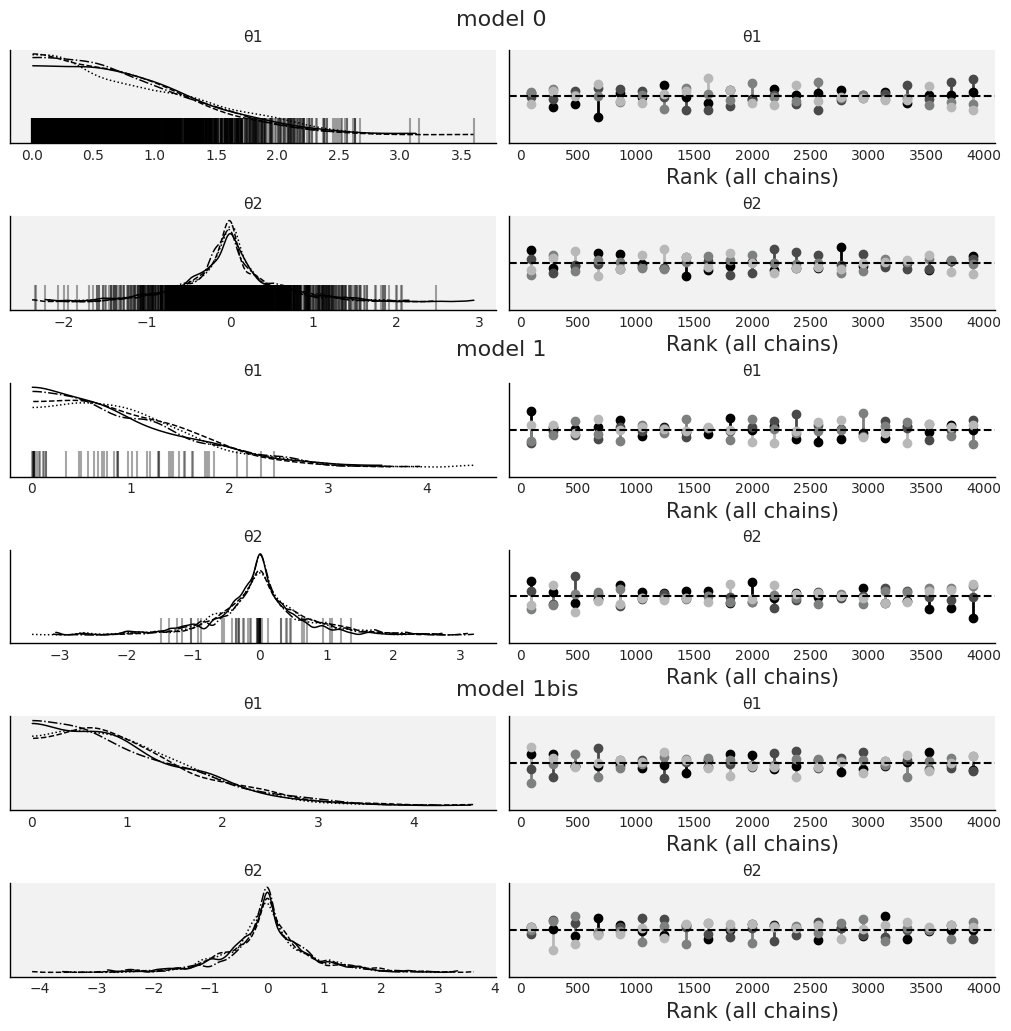

In [39]:
fig, axes = plt.subplots(6, 2, figsize=(10, 10))

axes = axes.reshape(3, 2, 2)
for idata, ax, color in zip(idatas, axes, ["0.95", "1", "0.95"]):
    az.plot_trace(idata, kind="rank_vlines", axes=ax);
    [ax_.set_facecolor(color) for ax_ in ax.ravel()]
fig.text(0.45, 1, s="model 0", fontsize=16)
fig.text(0.45, 0.67, s="model 1", fontsize=16)
fig.text(0.45, 0.33, s="model 1bis", fontsize=16)
plt.savefig("img/chp02/divergences_trace.png", bbox_inches="tight")

### Figure 2.15

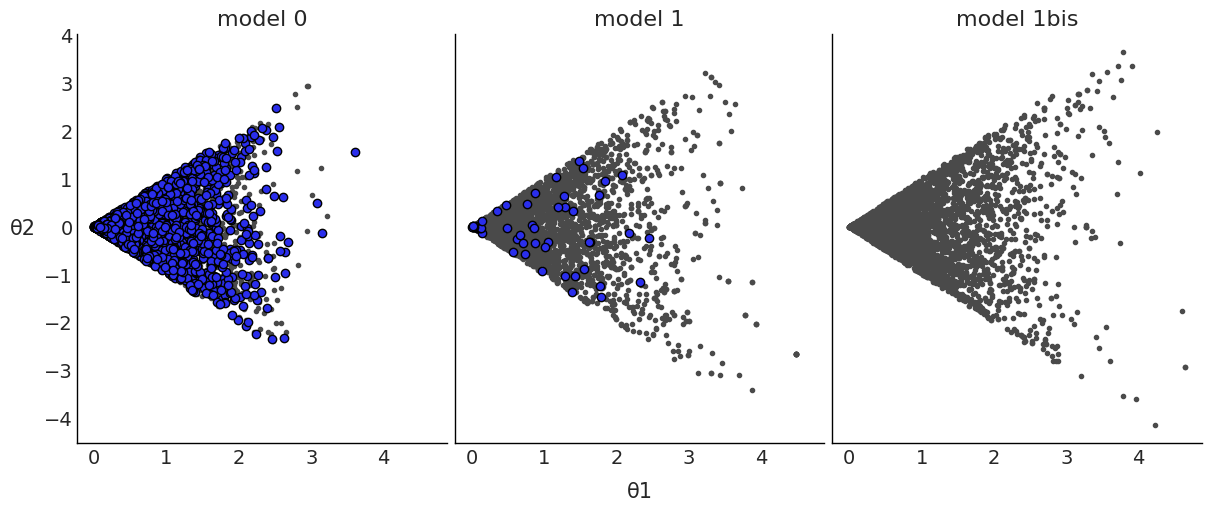

In [40]:
_, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)

for idata, ax, model in zip(idatas, axes, ["model 0", "model 1", "model 1bis"]):
    az.plot_pair(idata, divergences=True, scatter_kwargs={"color":"C1"}, divergences_kwargs={"color":"C4"}, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(model)
axes[0].set_ylabel('θ2', rotation=0, labelpad=15)
axes[1].set_xlabel('θ1', labelpad=10)
plt.savefig("img/chp02/divergences_pair.png")

## Model Comparison

### Code 2.15

In [41]:
np.random.seed(90210)

In [42]:
# π

### Notes
+ PSIS-LOO-CV - scoring measure book will refer to as LOO
+ What exactly is sample doing?

In [43]:
# y_obs - standard normal
y_obs =  np.random.normal(0, 1, size=100)

# mA Model is skewnormal mean at 0 (vs data is normal) with sigma half normal 1 
with pm.Model() as mA:
    # priors
    σ = pm.HalfNormal("σ", 1)
    
    y = pm.SkewNormal("y", 0, σ, alpha=1, observed=y_obs)
    # sample ? return inferencedata relates to if the data is returned as an arviz.InferenceData object 
    #    - which is an xarray (3d dataframe) data container
    # sample_posterior_predictive
    # sample_prior_predictive
    # first do the sample to create the joint distribution? and estimate the posteriors for the parameters
    # Not sure why you would use return inference data = False if we are all about
    # getting visibility at each stage on how the process is working - maybe time?
    posterior = pm.sample(return_inferencedata=False)
    idataA1 = az.from_pymc3(posterior)

    # # then pass the trace from sample to sample posterior predictive method to generate simulated target data
    # could this be sampling from the joint distribution created from the sample method

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [44]:
idataA1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [45]:
with pm.Model() as mA:
    y = pm.SkewNormal("y", 0, σ, alpha=1, observed=y_obs)
    posterior_predictive = pm.sample_posterior_predictive(posterior)
    idataA1.extend(az.from_pymc3(posterior_predictive=posterior_predictive))
    # # then pass the trace from sample to sample posterior predictive method
    # # and append it to the arviz inference data object generated by sample
    # # Seems like the data returned from sample posterior predictive has to be shaped[None,:] to be accepted into the xarray object
    # idataA1.add_groups({"posterior_predictive": {"y":pm.sample_posterior_predictive(idataA1)["y"][None,:]}})
    # idataA1.extend(az.from_pymc3(posterior_predictive=post_pred))

In [46]:
idataA1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> posterior_predictive

In [47]:
postp_df = idataA1.posterior_predictive.to_dataframe()
postp_df

y
chain draw y_dim_0          
0     0    0        1.138636
           1        0.953248
           2        1.215097
           3        0.251107
           4        1.656390
...                      ...
      3999 95      -0.897068
           96       1.003344
           97      -1.007449
           98       0.660583
           99       1.291831

[400000 rows x 1 columns]

In [48]:
postp_df.index.unique()

MultiIndex([(0,    0,  0),
            (0,    0,  1),
            (0,    0,  2),
            (0,    0,  3),
            (0,    0,  4),
            (0,    0,  5),
            (0,    0,  6),
            (0,    0,  7),
            (0,    0,  8),
            (0,    0,  9),
            ...
            (0, 3999, 90),
            (0, 3999, 91),
            (0, 3999, 92),
            (0, 3999, 93),
            (0, 3999, 94),
            (0, 3999, 95),
            (0, 3999, 96),
            (0, 3999, 97),
            (0, 3999, 98),
            (0, 3999, 99)],
           names=['chain', 'draw', 'y_dim_0'], length=400000)

In [49]:
# y_obs - standard normal
y_obs =  np.random.normal(0, 1, size=100)
idatas_cmp = {}

# mA Model is skewnormal mean at 0 (vs data is normal) with sigma half normal 1 
with pm.Model() as mA:
    # priors
    σ = pm.HalfNormal("σ", 1)
    y = pm.SkewNormal("y", 0, σ, alpha=1, observed=y_obs)
    # sample ? return inferencedata relates to if the data is returned as an arviz.InferenceData object
    # sample_posterior_predictive
    # sample_prior_predictive
    # first sample
    idataA = pm.sample(return_inferencedata=True)
    # then sample posterior predictive
    idataA.add_groups({"posterior_predictive": {"y":pm.sample_posterior_predictive(idataA)["y"][None,:]}})
    idatas_cmp["mA"] = idataA

# mB model normal centred at 0 with sigma half normal 1
with pm.Model() as mB:
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", 0, σ, observed=y_obs)
    idataB = pm.sample(return_inferencedata=True)
    idataB.add_groups({"posterior_predictive": {"y":pm.sample_posterior_predictive(idataB)["y"][None,:]}})
    idatas_cmp["mB"] = idataB

# model mC normal with mean as standard normal and sigma half normal 1
with pm.Model() as mC:
    μ = pm.Normal("μ", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", μ, σ, observed=y_obs)
    idataC = pm.sample(return_inferencedata=True)
    idataC.add_groups({"posterior_predictive": {"y":pm.sample_posterior_predictive(idataC)["y"][None,:]}})
    idatas_cmp["mC"] = idataC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8819512382035946, but should be close to 0.8. Try to increase the number of tuning steps.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [50]:
idatas_cmp

{'mA': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data
 	> posterior_predictive,
 'mB': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data
 	> posterior_predictive,
 'mC': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data
 	> posterior_predictive}

## Cross Validation & LOO

#3# Table 2.1

In [51]:
# compare needs posterior predictive
cmp = az.compare(idatas_cmp, scale='log')
cmp.round(2)

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
mB,0,-149.67,0.90,0.00,1.0,6.69,0.00,False,log
mC,1,-150.53,1.83,0.86,0.0,6.64,0.46,False,log
mA,2,-177.29,1.29,27.62,0.0,10.18,6.68,False,log


The first column is the index which lists the names of the models taken from the keys of the dictionary passed to az.compare(.).
+ [arviz.compare](https://python.arviz.org/en/0.14.0/api/generated/arviz.compare.html)
+ rank: The ranking of the models starting from 0 (the model with the highest predictive accuracy) to the number of models.
+ loo: The list of ELPD values. The DataFrame is always sorted from best ELPD to worst.
+ p_loo: The list of values for the penalization term. We can roughly think of this value as the estimated effective number of parameters (but do not take that too seriously). This value can be lower than the actual number of parameters in a model that has more structure like a hierarchical model or can be much higher than the actual number when the model has very weak predictive capability and may indicate a severe model misspecification.
+ d_loo: The list of relative differences between the value of LOO for the top-ranked model and the value of LOO for each model. For this reason we will always get a value of 0 for the first model.
+ weight: The weights assigned to each model. These weights can be loosely interpreted as the probability of each model (among the compared models) given the data. See Section Model Averaging for details.
+ se: The standard error for the ELPD computations.
+ dse: The standard errors of the difference between two values of the ELPD. dse is not necessarily the same as the se because the uncertainty about the ELPD can be correlated between models. The value of dse is always 0 for the top-ranked model.
+ warning: If True this is a warning that the LOO approximation may not be reliable (see Section Pareto Shape Parameter for details).
+ loo_scale: The scale of the reported values. The default is the log scale. Other options are deviance, this is the log-score multiplied by -2 (this will reverse the order: a lower ELPD will be better). And negative-log, this is the log-score multiplied by -1, as with the deviance scale, a lower value is better.


### Figure 2.16

In [52]:
# import arviz.labels as azl

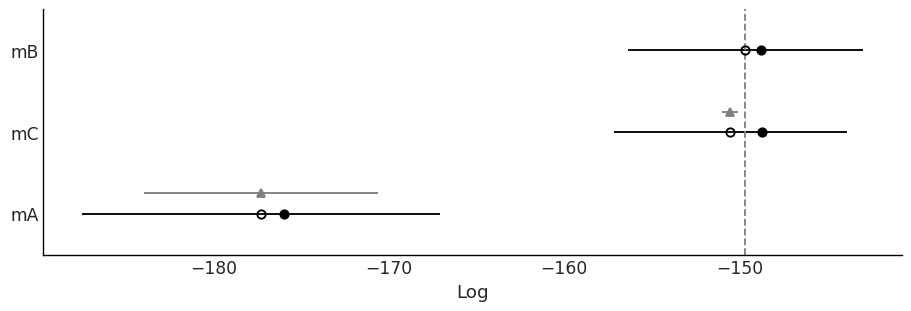

In [53]:
az.plot_compare(cmp, figsize=(9, 3))
plt.savefig("img/chp02/compare_dummy.png")
# lower (right side) better than higher (left) comparing log scale

## Expected Log Predictive Density

### Figure 2.17

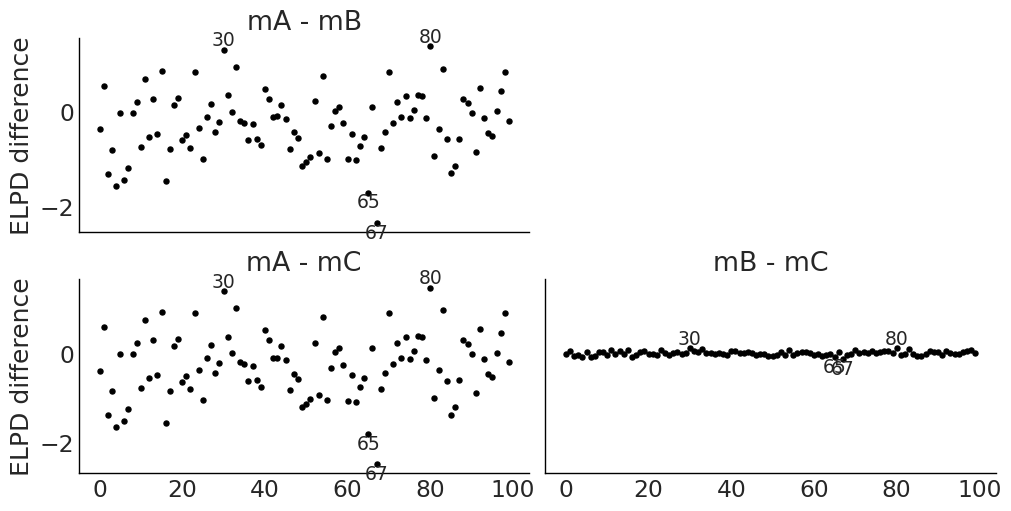

In [54]:
az.plot_elpd(idatas_cmp, figsize=(10, 5), plot_kwargs={"marker":"."}, threshold=2);
plt.savefig("img/chp02/elpd_dummy.png")

+ The intent is to review how well each model performs at a certain point within the data
+ plot pairwise comparison of models
+ Take first plot mA - mB
    + +ve values at 49 and 72 indicate mA performed better here than mB
    + -ve vales at 75 and 95 indicate mA performed worse here than mB
+ Third plot mB and mC are very similar across the board
+ We will see in fig 2.19 that 34, 49, 72, 75, 82 are the most extreme observations

## Pareto Shape Parameter
+ Calculate a measure called K_hat
+ Higher K_hats indicate potential problem with the model
+ Seems like threshold is K_hat > 0.7 (?) - gives a warning in the LOO table output warnings column
+ Detect highly inflential observations for each model
+ But, what causes an observation to be highly inflential - maybe an outlier?

### Figure 2.18

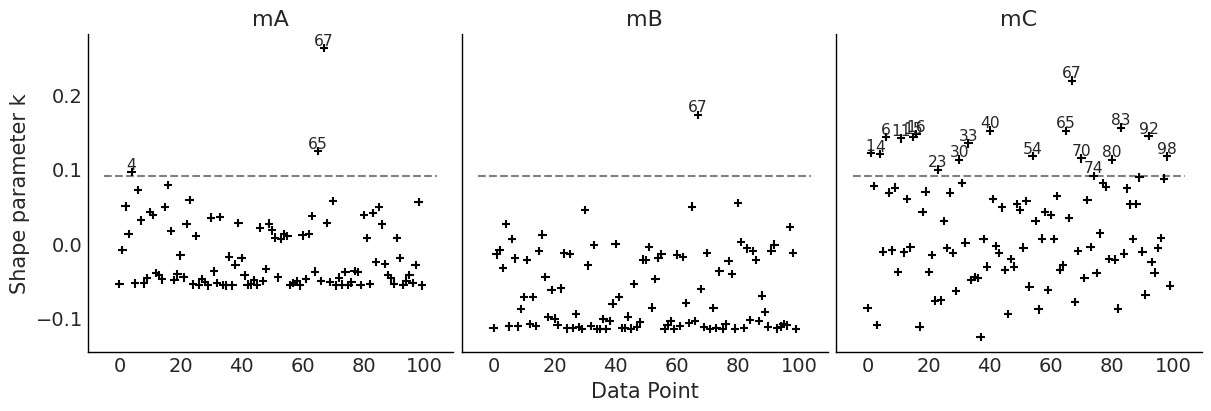

In [55]:
_, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for idx, (model, ax) in enumerate(zip(("mA", "mB", "mC"), axes)):
    loo_ = az.loo(idatas_cmp[model], pointwise=True)
    az.plot_khat(loo_, ax=ax, threshold=0.09, show_hlines=True, hlines_kwargs={"hlines":0.09, "ls":"--"})
    ax.set_title(model)
    if idx:
        axes[idx].set_ylabel("")
    if not idx % 2:
        axes[idx].set_xlabel("")

plt.savefig("img/chp02/loo_k_dummy.png")

### Figure 2.19

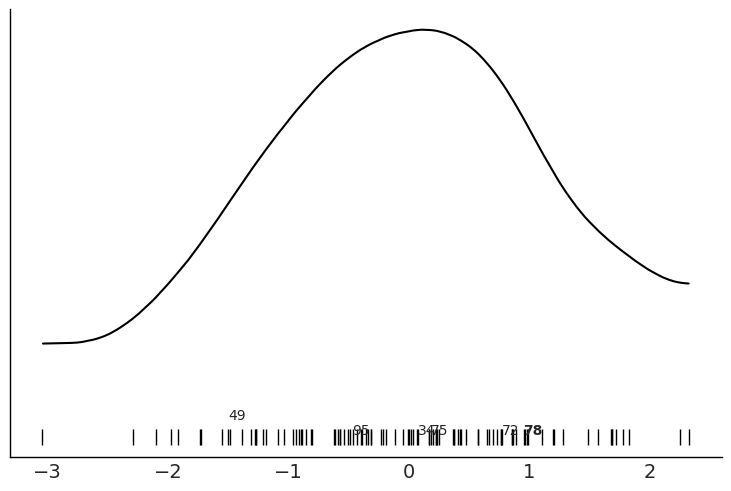

In [56]:
az.plot_kde(y_obs, rug=True)
plt.yticks([])
for da, loc in zip([34, 49, 72, 75, 95], [-0.065, -0.05, -0.065, -0.065, -0.065]):
    plt.text(y_obs[da], loc, f"{da}")

plt.text(y_obs[78], loc, "78", fontweight='bold');
plt.savefig("img/chp02/elpd_and_khat.png")

+ Kernel density estimate of the observations fitted with mA, mB and mC. The black lines represent the values of each observation. The annotated observations are the same one highlighted in Fig. 2.17 except for the observation 78, annotated in boldface, which is only highlighted in Fig. 2.18.

### Interpreting p_loo when Pareto K_hat is large
+ p_loo from model comparison table, p is number of model parameters
+ p_loo << p - model likely misspecified. should also see in posterior predictive checks
+ p_loo < p  and p > number of observations / 5. model too flexible or priors too uninformative
+ p_loo > p model likely badly misspecified. if p << N then posterior predictive checks likely reveal a problem. But if p relatively large (p > number of obs. /5) then maybe no problem appears in posterior predictive checks

### LOO-PIT
+ Maths, maths
+ For a well calibrated model we should expect to see a normal distribution
+ Same technique as used in checking predictions

### Figure 2.20

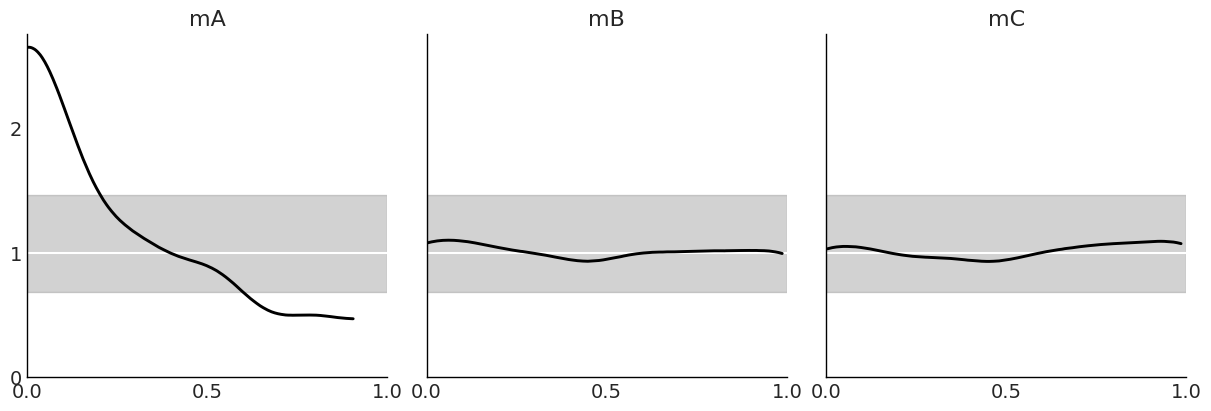

In [57]:
_, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for model, ax in zip(("mA", "mB", "mC"), axes):
    az.plot_loo_pit(idatas_cmp[model], y="y", legend=False, use_hdi=True, ax=ax)
    ax.set_title(model)
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 1, 2])

plt.savefig("img/chp02/loo_pit_dummy.png")

# Model Averaging
+ Bayesian Model Averaging
+ Model Stacking
+ weights from az.compare table should be used
+ Below - use weighted models to sample from posterior

In [58]:
# y_obs - standard normal
y_obs =  np.random.normal(0, 1, size=100)
idatas_cmp = {}

# mA Model is skewnormal mean at 0 (vs data is normal) with sigma half normal 1 
with pm.Model() as mA:
    # priors
    σ = pm.HalfNormal("σ", 1)
    y = pm.SkewNormal("y", 0, σ, alpha=1, observed=y_obs)
    # sample ? return inferencedata relates to if the data is returned as an arviz.InferenceData object
    # sample_posterior_predictive
    # sample_prior_predictive
    # first sample
    idataA = pm.sample(return_inferencedata=False)
    # then sample posterior predictive
    # idataA.add_groups({"posterior_predictive": {"y":pm.sample_posterior_predictive(idataA)["y"][None,:]}})
    # idatas_cmp["mA"] = idataA

# mB model normal centred at 0 with sigma half normal 1
with pm.Model() as mB:
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", 0, σ, observed=y_obs)
    idataB = pm.sample(return_inferencedata=False)
    # idataB.add_groups({"posterior_predictive": {"y":pm.sample_posterior_predictive(idataB)["y"][None,:]}})
    # idatas_cmp["mB"] = idataB

# model mC normal with mean as standard normal and sigma half normal 1
with pm.Model() as mC:
    μ = pm.Normal("μ", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", μ, σ, observed=y_obs)
    idataC = pm.sample(return_inferencedata=False)
    # idataC.add_groups({"posterior_predictive": {"y":pm.sample_posterior_predictive(idataC)["y"][None,:]}})
    # idatas_cmp["mC"] = idataC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [59]:
with pm.Model() as model_weighted_equal:
    weighted_equal = pm.sample_posterior_predictive_w([idataA, idataB, idataC], models=[mA, mB, mC])
weighted_equal

{'y': array([[-0.44694435,  1.37297005, -0.17188977, ...,  0.76159155,
          0.36678672, -0.19262316],
        [-1.56238784,  1.33084905,  1.37697217, ..., -0.32823507,
          0.17132649,  0.40203837],
        [ 1.25414462,  0.41373209,  1.70493325, ...,  0.9202214 ,
          0.00618338,  1.86153353],
        ...,
        [ 1.39950665,  0.23560337,  0.36637996, ...,  1.6573467 ,
          0.66803961,  0.67541302],
        [ 0.00793727, -0.5292511 ,  0.39568595, ..., -0.96887908,
         -1.78150783,  0.73308219],
        [-0.26245509, -0.3885438 ,  0.79951452, ..., -0.61761276,
          0.2942479 ,  0.11236676]])}

In [60]:
weighted_equal['y'].shape

(4000, 100)

In [61]:
weighted_equal_df = pd.DataFrame(weighted_equal['y'])[0:500].T.reset_index().melt(id_vars='index').assign(weighted='equal')
weighted_equal_df

,index,variable,value,weighted
0,0,0,-0.446944,equal
1,1,0,1.372970,equal
2,2,0,-0.171890,equal
3,3,0,1.688303,equal
4,4,0,-0.346938,equal
...,...,...,...,...
49995,95,499,-0.393628,equal
49996,96,499,0.823181,equal
49997,97,499,-0.800334,equal
49998,98,499,-1.131480,equal


In [62]:
with pm.Model() as model_weighted:
    weighted = pm.sample_posterior_predictive_w([idataA, idataB, idataC], models=[mA, mB, mC], weights=[0.98, 0.1, 0.1])
weighted_df = pd.DataFrame(weighted['y'])[0:500].T.reset_index().melt(id_vars='index').assign(weighted='biased')

In [63]:
df = pd.concat([weighted_equal_df, weighted_df], axis=0)

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/plotnine/facets/facet_wrap.py:216: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


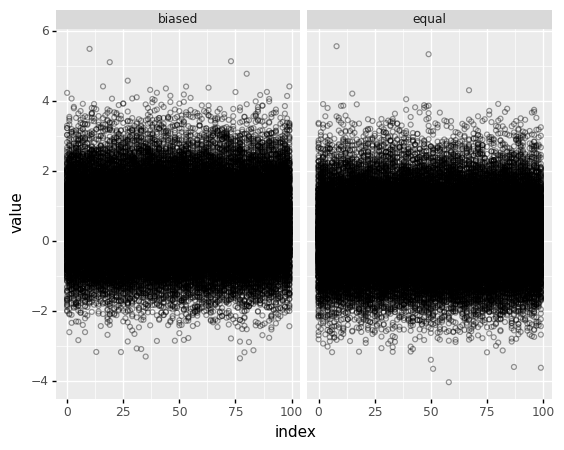

In [64]:
p = (ggplot(df, aes(x='index', y='value')) +
     geom_point(fill='none', alpha=0.4) +
     facet_wrap('weighted')
    )
p.draw();

In [65]:
# 2M11

In [66]:
with pm.Model() as model:
    μ = pm.Gamma("μ", 0.5, 0.00001)
    score = pm.Poisson("score", μ)
    trace = pm.sample_prior_predictive()

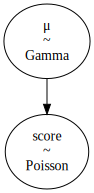

In [67]:
pm.model_to_graphviz(model)

array([[<AxesSubplot:title={'center':'μ_log__'}>,
        <AxesSubplot:title={'center':'μ_log__'}>],
       [<AxesSubplot:title={'center':'score'}>,
        <AxesSubplot:title={'center':'score'}>],
       [<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>]], dtype=object)

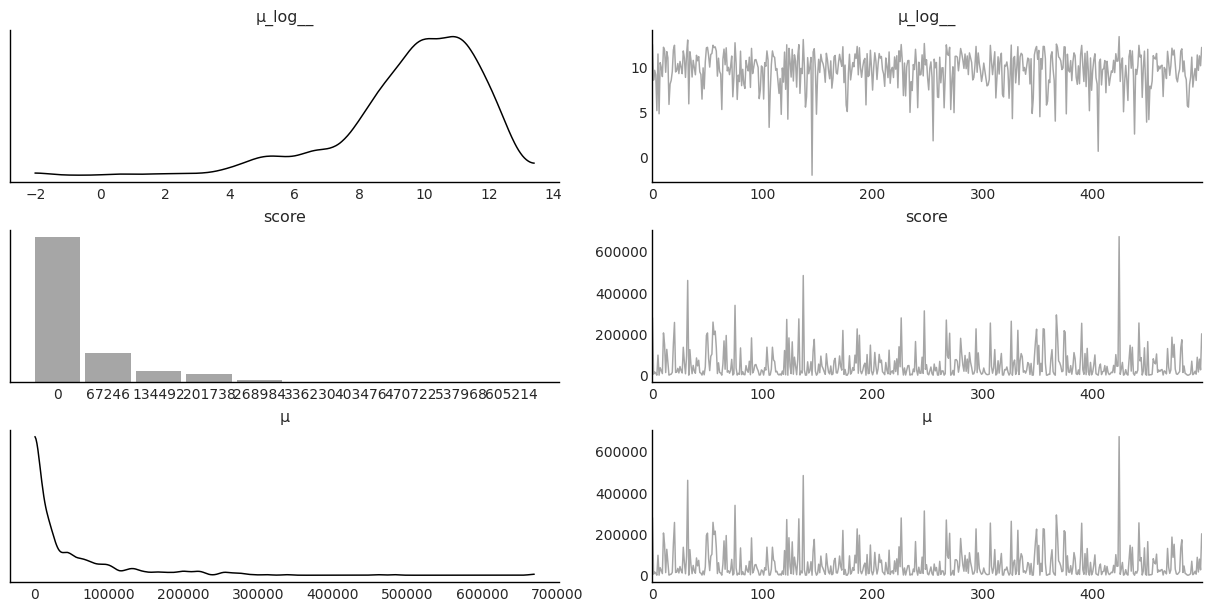

In [68]:
pm.plot_trace(trace)